In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import env

import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import itertools

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import acquire
import prepare

from IPython.display import display

## 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [9]:
url = env.get_db_url('grocery_db')
sql = '''SELECT * FROM grocery_customers'''
df = pd.read_sql(sql, url)
for col in df.columns:
    df = df.rename(columns={col: col.lower()})
df = df.rename(columns={'delicassen': 'deli'})
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   channel           440 non-null    int64
 2   region            440 non-null    int64
 3   fresh             440 non-null    int64
 4   milk              440 non-null    int64
 5   grocery           440 non-null    int64
 6   frozen            440 non-null    int64
 7   detergents_paper  440 non-null    int64
 8   deli              440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [11]:
cols = ['fresh', 'milk', 'grocery', 'frozen', 
        'detergents_paper', 'deli']

### scaling

In [12]:
scaler = MinMaxScaler()
for col in cols:
    scaler.fit(df[[col]])
    df[f'scaled_{col}'] = scaler.transform(df[[col]])

In [13]:
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli
0,0,2,3,12669,9656,7561,214,2674,1338,0.112940,0.130727,0.081464,0.003106,0.065427,0.027847
1,1,2,3,7057,9810,9568,1762,3293,1776,0.062899,0.132824,0.103097,0.028548,0.080590,0.036984
2,2,2,3,6353,8808,7684,2405,3516,7844,0.056622,0.119181,0.082790,0.039116,0.086052,0.163559
3,3,1,3,13265,1196,4221,6404,507,1788,0.118254,0.015536,0.045464,0.104842,0.012346,0.037234
4,4,2,3,22615,5410,7198,3915,1777,5185,0.201626,0.072914,0.077552,0.063934,0.043455,0.108093


### DBSCAN

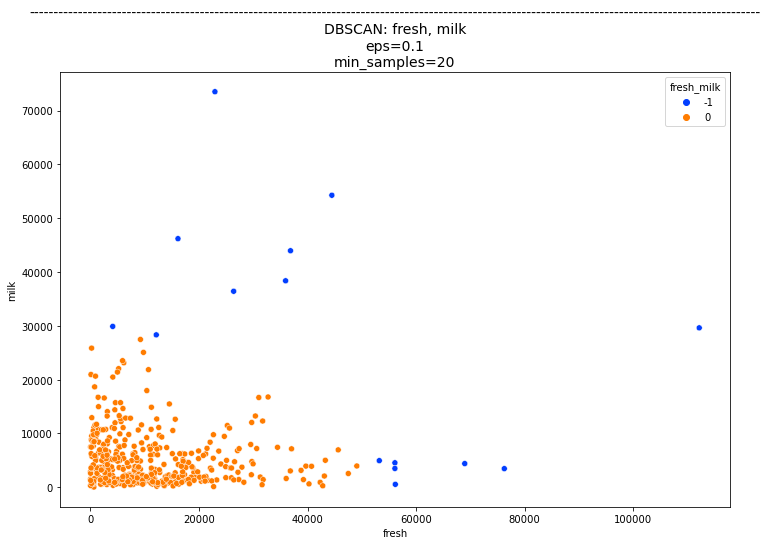

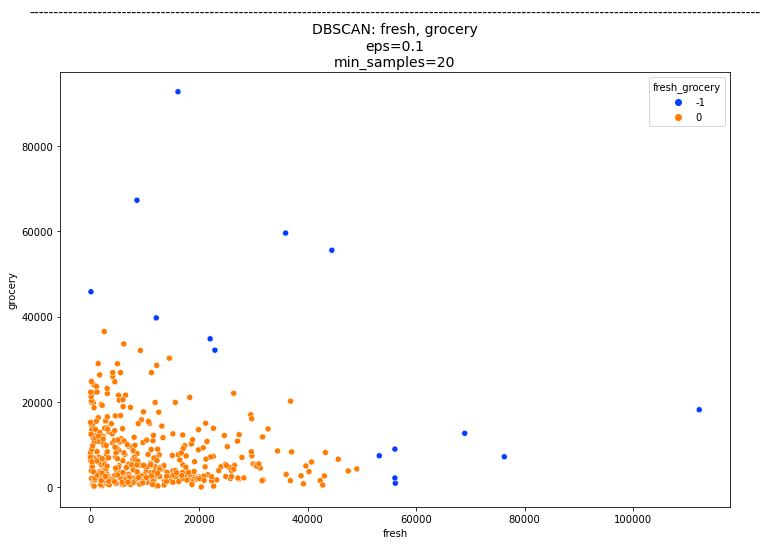

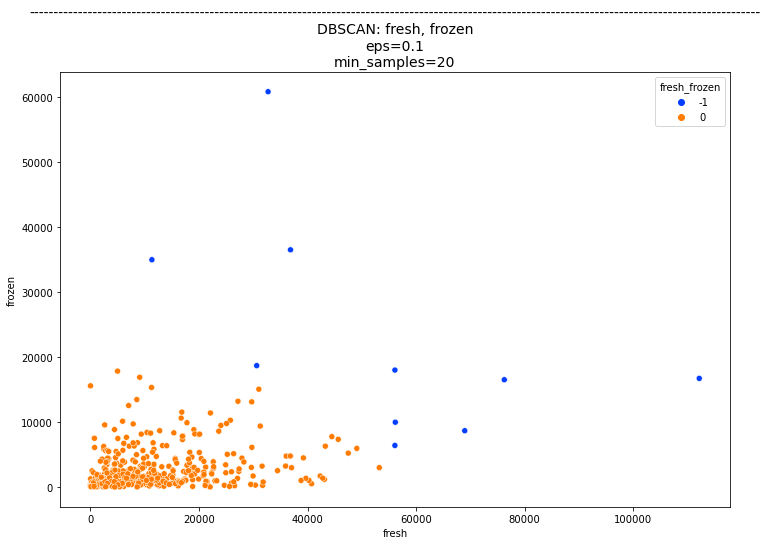

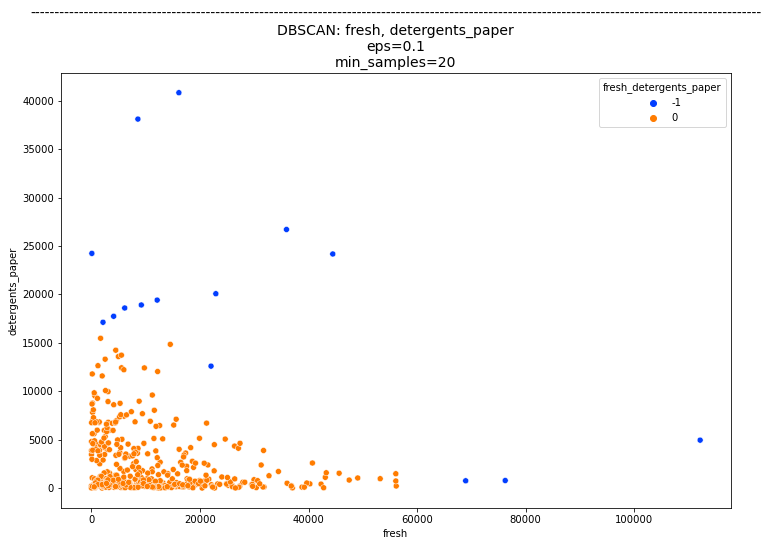

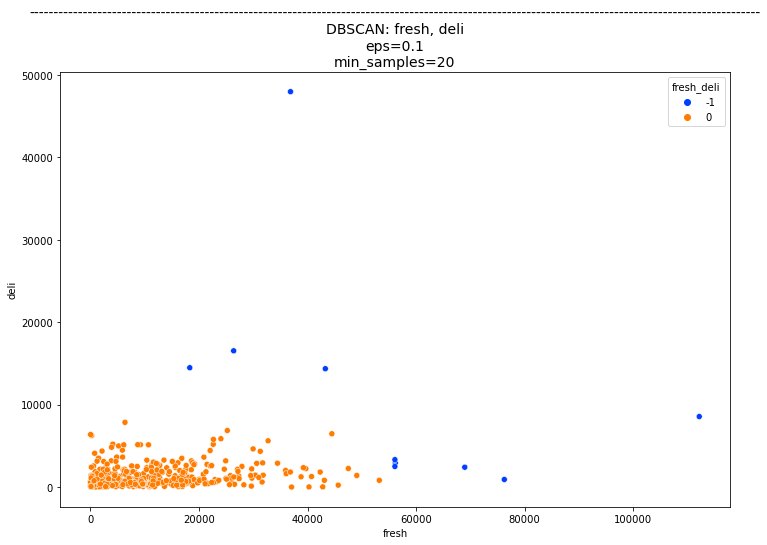

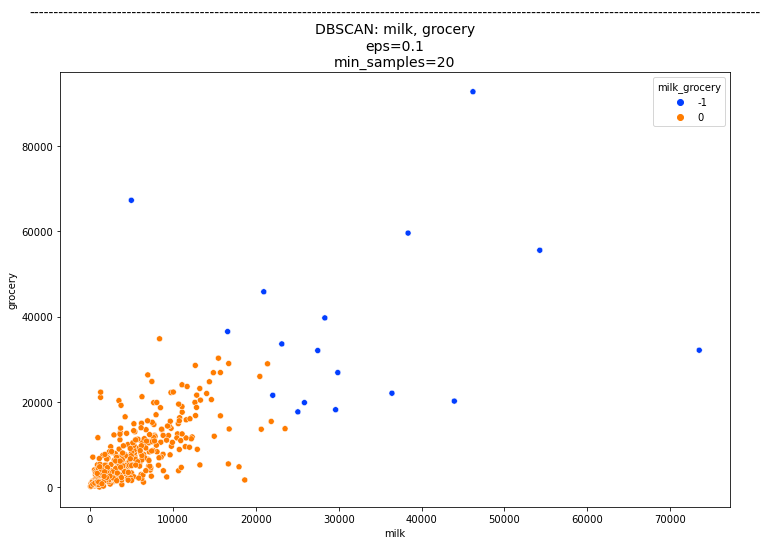

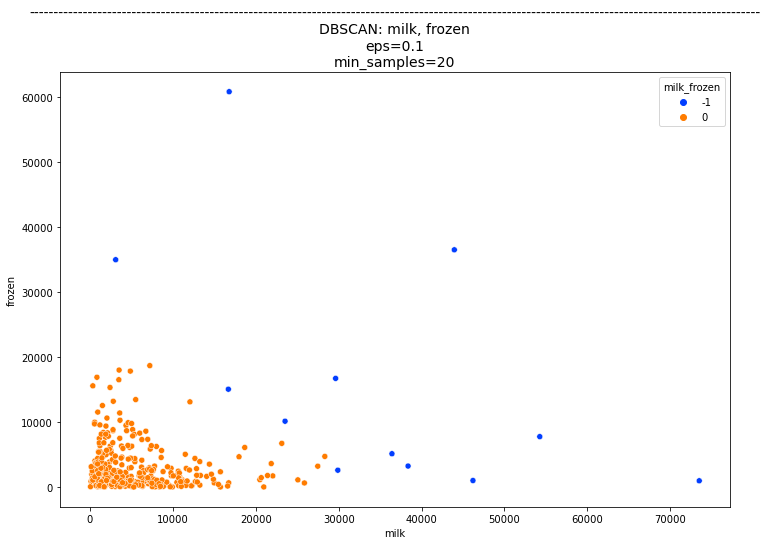

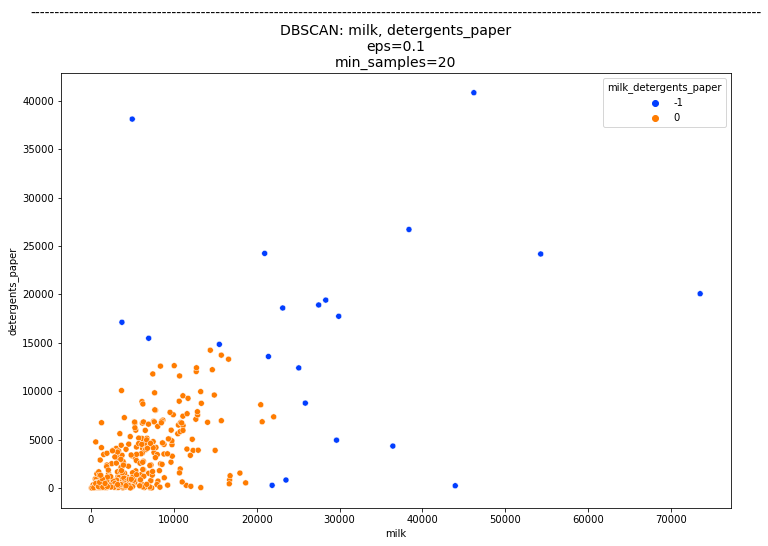

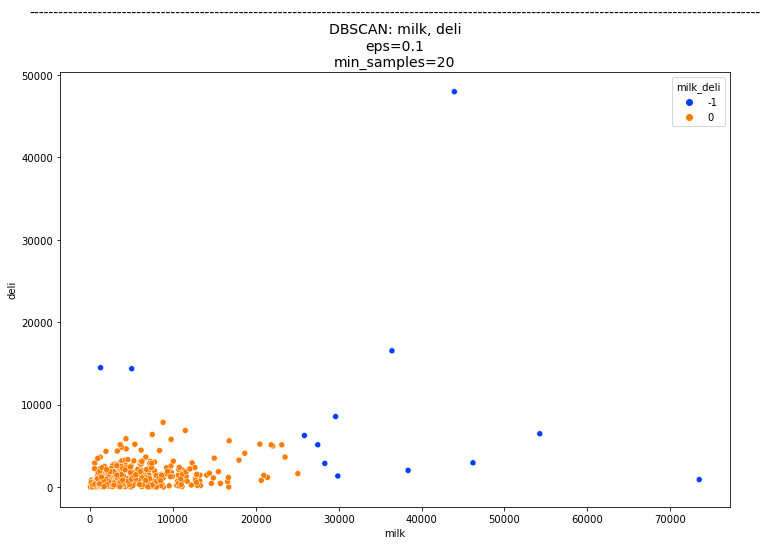

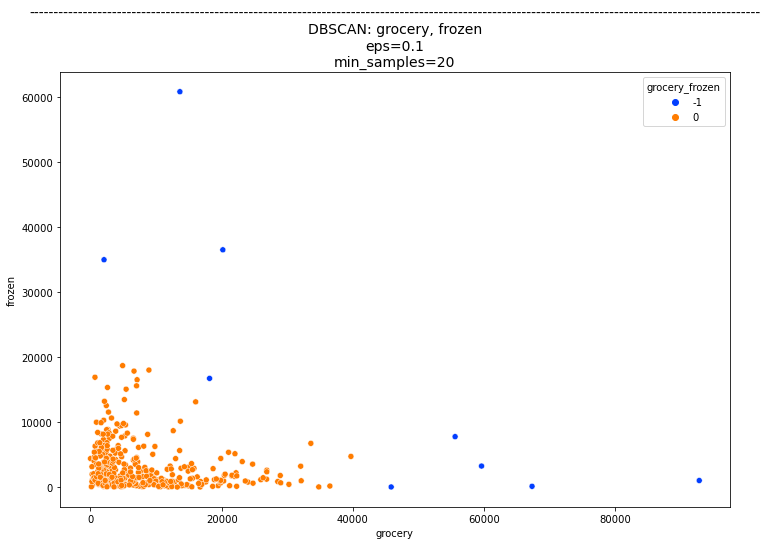

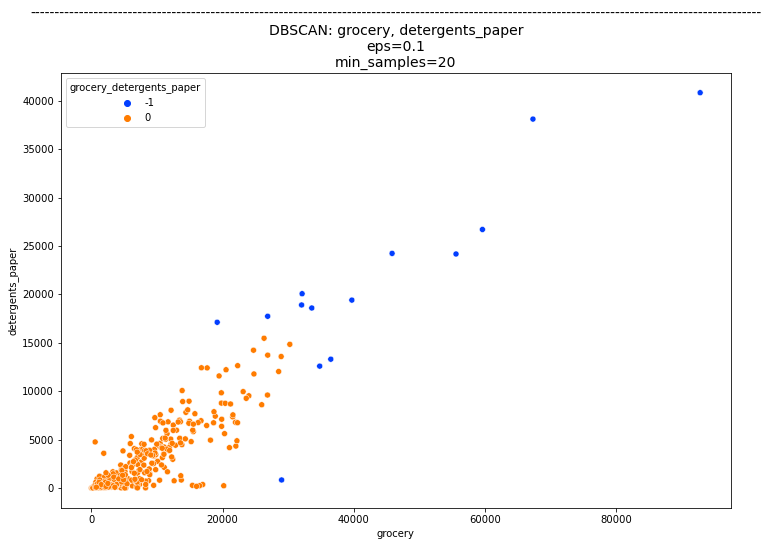

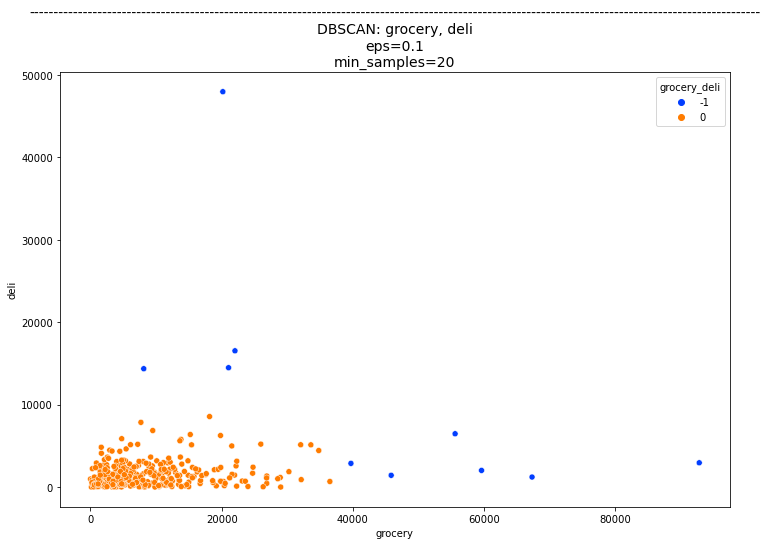

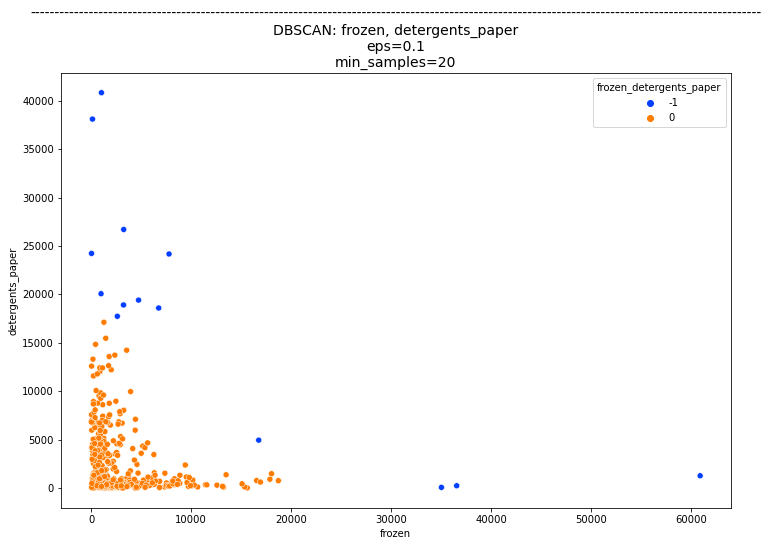

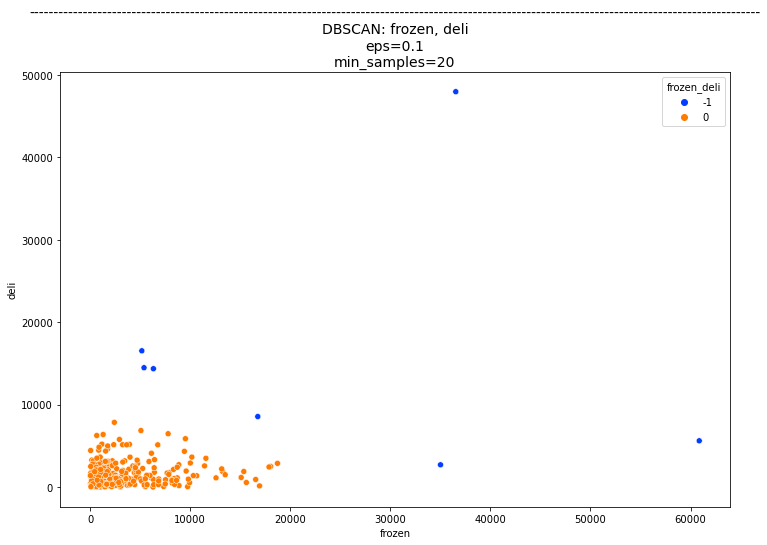

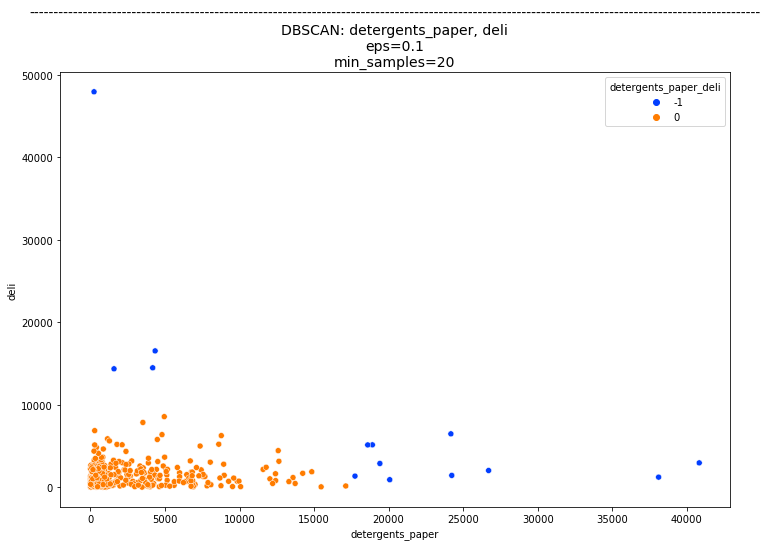

In [14]:
feature_set = ['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'deli']
feature_combos = itertools.combinations_with_replacement(feature_set, 2)

# establish hyperparameters
eps = .1
min_samples = 20

# for every combination of two features
for combo in feature_combos:
    if combo[0] != combo[1]:

        # establish a feature set
        features = combo

        # create the dbscan object
        dbsc = DBSCAN(eps=eps, min_samples=min_samples)

        # fit the dbscan object 
        dbsc.fit(df[[f'scaled_{features[0]}', f'scaled_{features[1]}']])

        # add the dbscan labels as a new column to the df
        df[f'{features[0]}_{features[1]}'] = dbsc.labels_

        # plot the results
        plt.figure(figsize=(12,8))
        sns.scatterplot(df[features[0]], df[features[1]], 
                        hue=df[f'{features[0]}_{features[1]}'], 
                        palette='bright')
        plt.title(f'{"-"*150}\nDBSCAN: {features[0]}, {features[1]}\neps={eps}\nmin_samples={min_samples}',
                  fontdict={'fontsize':14})
        plt.show()

## 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [15]:
# url = env.get_db_url('curriculum_logs')
# sql = '''
# SELECT cohorts.slack, logs.*
#    FROM logs
#      LEFT JOIN cohorts ON cohorts.id=logs.cohort_id
# '''
# df = pd.read_sql(sql, url)

In [16]:
# # caching
# df.to_csv('curriculum_logs.csv')

In [17]:
df = pd.read_csv('curriculum_logs.csv').drop(columns='Unnamed: 0')

# cleaning
df['cohort'] = np.where(df.slack == '#', '#other', df.slack)
df['cohort'] = df.cohort.str[1:]
df = df.drop(columns=['slack', 'cohort_id'])
df['datetime'] = pd.to_datetime(df.date + ' ' + df.time)
df = df.rename(columns={'path': 'page'})

In [18]:
df.head()

,date,time,page,user_id,ip,cohort,datetime
0,2018-01-26,09:55:03,/,1,97.105.19.61,hampton,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,hampton,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,hampton,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,hampton,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,teddy,2018-01-26 09:56:24


#### Anomolies in counts by user_id

In [19]:
id_counts = df.groupby('user_id')['date', 'cohort', 'page', 'ip'].nunique()
id_counts

,date,cohort,page,ip
user_id,,,,
1,637,2,976,35
2,83,1,151,12
3,107,1,169,25
4,54,1,143,11
5,82,1,197,4
...,...,...,...,...
977,10,1,12,6
978,9,1,18,4
979,9,1,20,7


In [20]:
def scale_data(df, cols, scaler=MinMaxScaler()):
    '''
    Scales each of a given set of columns in a dataframe and 
    adds new columns of scaled values back to the original dataframe, 
    using the prefix 'scaled_'.
    '''
    for col in cols:
        scaler.fit(df[[col]])
        df[f'scaled_{col}'] = scaler.transform(df[[col]])
    return df

In [22]:
def run_dbscan(df, cols, n_features, eps, min_samples):
    '''
    Runs a DBSCSAN on each possible combination of n_features from a given 
    set of columns in a dataframe. Adds new columns to the original dataframe with 
    the resulting DBSCAN labels for each combination. Displays a plot of the values, 
    color-coded according to their DBSCAN label for each combination. NOTE: as of now 
    this function really only works for n_features=2.
    '''
    # create a list of all possible combinations of features 
    feature_combos = itertools.combinations_with_replacement(cols, n_features)
    # for every combination of two features
    for combo in feature_combos:
        if combo[0] != combo[1]:
            # establish a feature set
            features = combo
            # create the dbscan object
            dbsc = DBSCAN(eps=eps, min_samples=min_samples)
            # fit the dbscan object 
            dbsc.fit(df[[f'scaled_{features[0]}', f'scaled_{features[1]}']])
            # add the dbscan labels as a new column to the df
            df[f'{features[0]}_{features[1]}'] = dbsc.labels_
            # plot the results
            plt.figure(figsize=(12,8))
            sns.scatterplot(df[features[0]], df[features[1]], 
                            hue=df[f'{features[0]}_{features[1]}'], 
                            palette='bright')
            plt.title(f'{"-"*150}\nDBSCAN: {features[0]}, {features[1]}\neps={eps}\nmin_samples={min_samples}',
                      fontdict={'fontsize':14})
            plt.show()

In [21]:
id_counts = scale_data(id_counts, ['date', 'cohort', 'page', 'ip'])

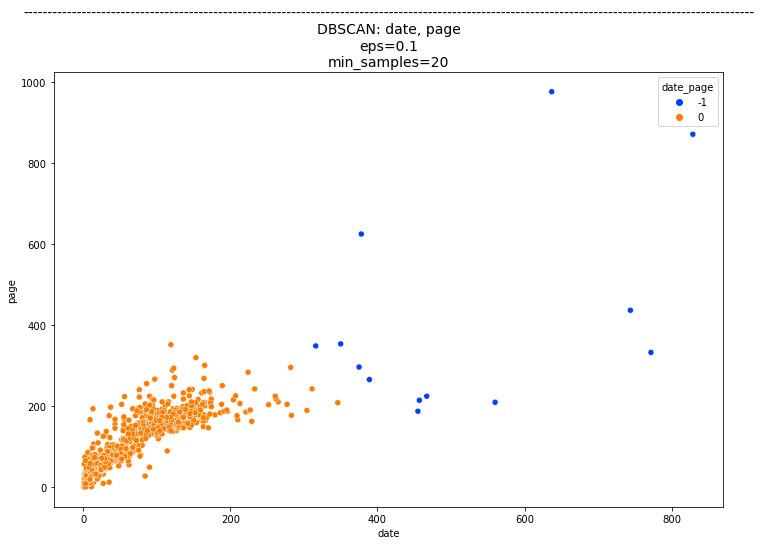

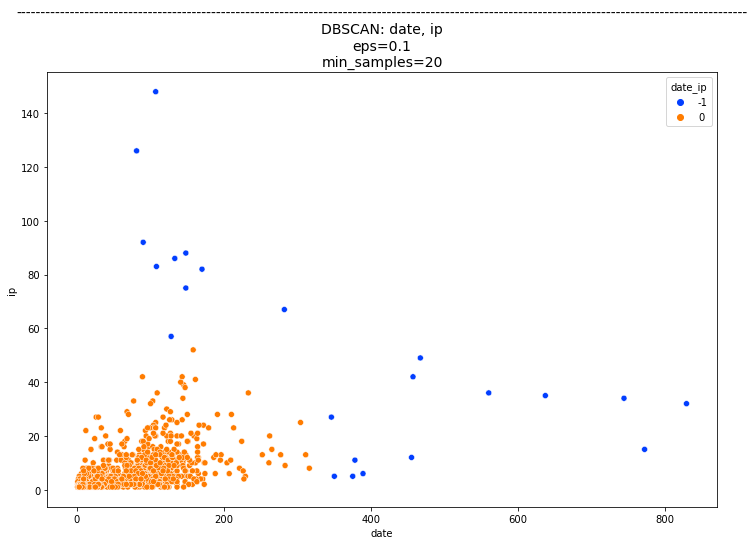

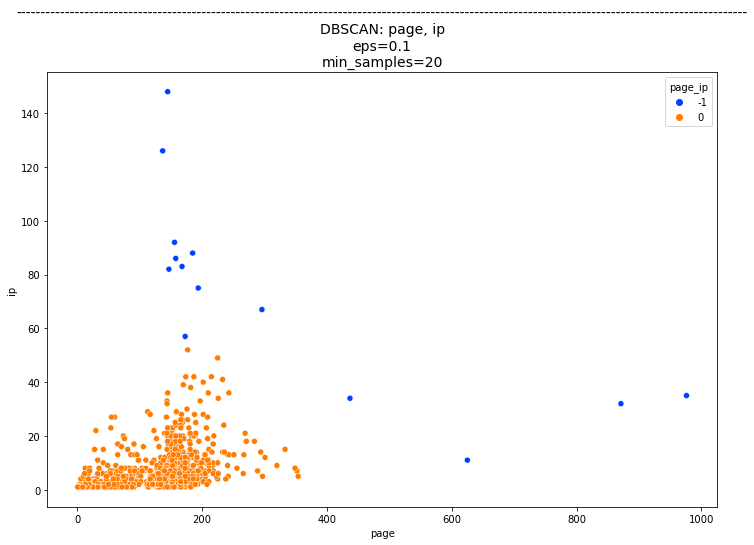

In [23]:
cols = ['date', 'page', 'ip']
n_features = 2

# establish hyperparameters
eps = .1
min_samples = 20

run_dbscan(id_counts, cols, n_features, eps, min_samples)

#### anomalies in counts by cohort

In [24]:
cohort_counts = df.groupby('cohort')['date', 'user_id', 'page', 'ip'].nunique()
cohort_counts

,date,user_id,page,ip
cohort,,,,
andromeda,447,28,366,152
apex,386,24,273,135
apollo,1,1,4,1
arches,278,18,342,46
badlands,12,3,44,6
bash,252,23,275,92
betelgeuse,430,22,334,129
ceres,466,29,301,239
curie,372,21,418,266


In [33]:
cols = ['date', 'user_id', 'page', 'ip']
cohort_counts = scale_data(cohort_counts, cols)

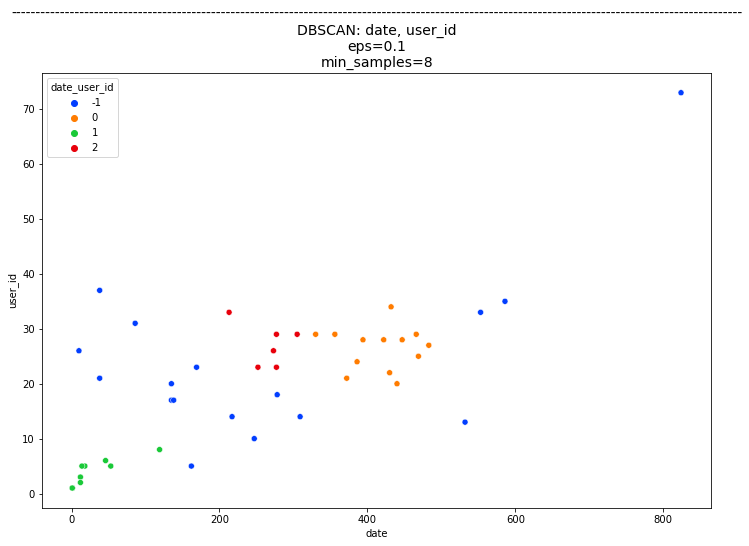

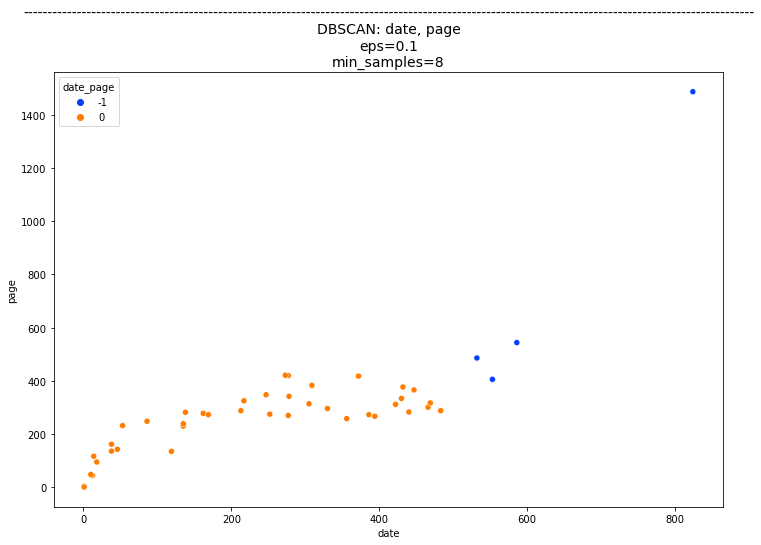

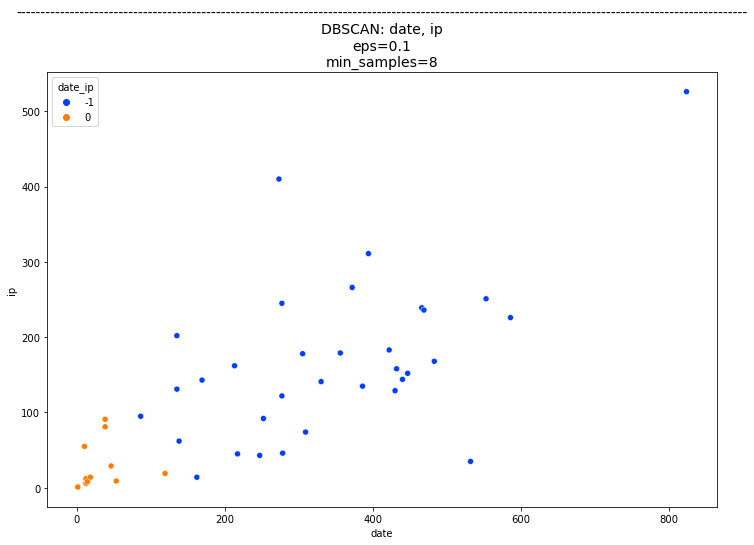

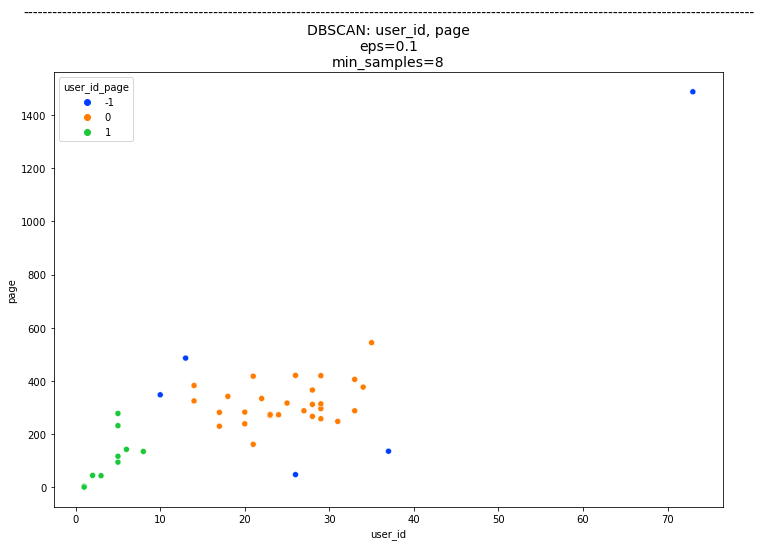

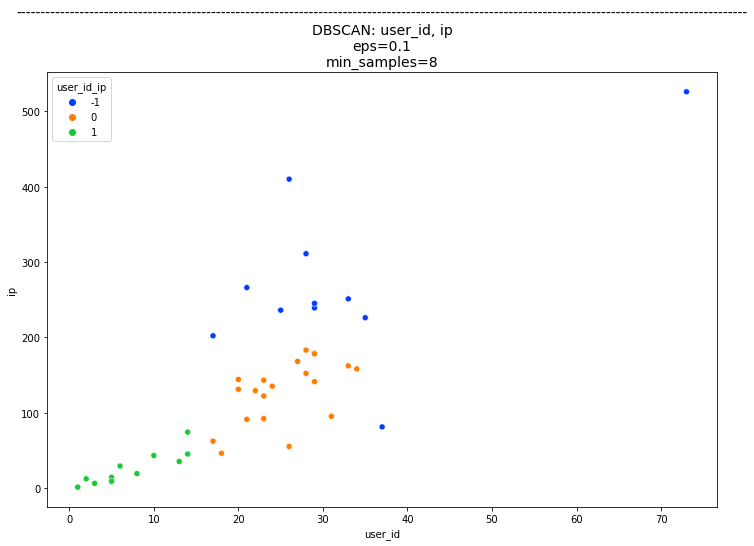

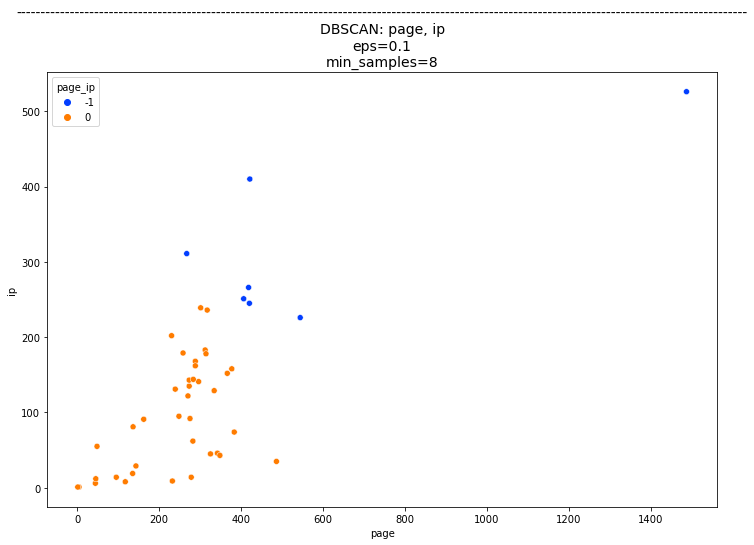

In [36]:
n_features = 2
eps = .1
min_samples = 8
run_dbscan(cohort_counts, cols, n_features, eps, min_samples)

#### page view anomalies

In [27]:
page_views = df.groupby(['user_id'])['page'].agg(['count', 'nunique'])
page_views

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [28]:
cols = ['count', 'nunique']
page_views = scale_data(page_views, cols)

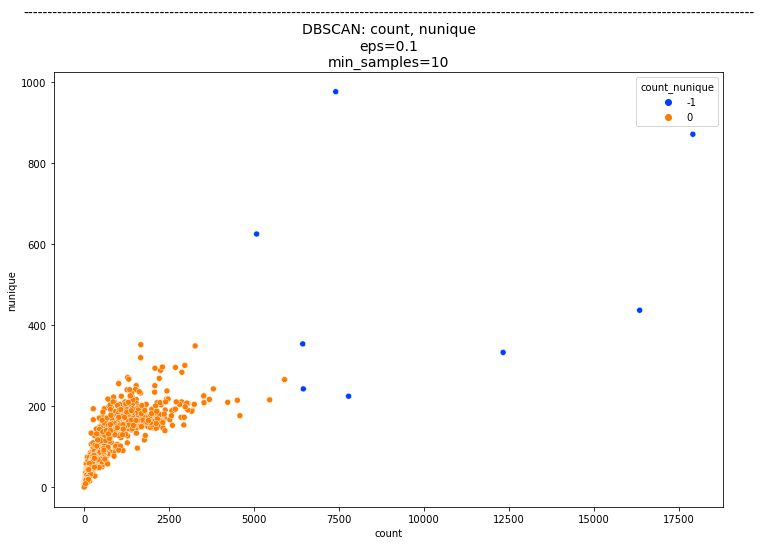

In [29]:
n_features = 2
eps = .1
min_samples = 10
run_dbscan(page_views, cols, n_features, eps, min_samples)

## 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [42]:
df = acquire.zillow_data()
df = prepare.prep_zillow(df)
df.head()

Reading from local CSV...


,bathroomcnt,bedroomcnt,sqft,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,bool_hashottuborspa,latitude,...,propertylandusedesc,age,bool_has_garage,bool_has_pool,bool_has_fireplace,taxvalue_per_sqft,taxvalue_per_bedroom,taxvalue_per_bathroom,abs_logerror,logerror_direction
0,3.5,4.0,3100.0,06059,0.0,3.0,2.0,633.0,0,33.634931,...,Single Family Residential,19,1,0,0,330.090968,255820.500000,136437.600000,0.025595,high
1,1.0,2.0,1465.0,06111,1.0,1.0,1.0,0.0,0,34.449266,...,Single Family Residential,50,1,0,1,316.723549,232000.000000,154666.666667,0.055619,high
2,2.0,3.0,1243.0,06059,0.0,2.0,2.0,440.0,0,33.886168,...,Single Family Residential,55,1,1,0,454.366854,188259.333333,112955.600000,0.005383,high
3,3.0,4.0,2376.0,06037,0.0,3.0,0.0,0.0,0,34.245180,...,Single Family Residential,47,0,1,0,61.087121,36285.750000,20734.714286,0.103410,low
6,3.0,4.0,2962.0,06037,0.0,3.0,0.0,0.0,0,34.145202,...,Single Family Residential,67,0,1,0,261.074612,193325.750000,110471.857143,0.001011,low


In [48]:
cols = ['bedroomcnt', 'sqft']
df = scale_data(df, cols)

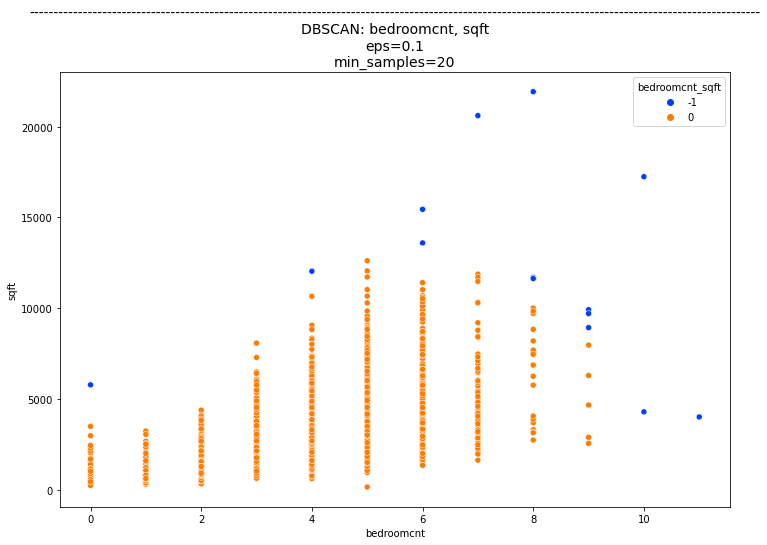

In [49]:
n_features = 2
eps = .1
min_samples = 20
run_dbscan(df, cols, n_features, eps, min_samples)

In [59]:
for col in df.columns:
    display(pd.DataFrame(df[col].value_counts()))
    

,bathroomcnt
2.0,21795
3.0,10534
1.0,9471
2.5,3914
4.0,2150
3.5,908
1.5,826
5.0,768
4.5,679
6.0,299


,bedroomcnt
3.0,23208
4.0,15074
2.0,8238
5.0,3904
6.0,625
1.0,573
7.0,102
0.0,29
8.0,24
9.0,8


,sqft
1120.0,128
1200.0,118
1080.0,102
936.0,86
1040.0,83
...,...
7088.0,1
604.0,1
5422.0,1
534.0,1


,fips
06037,33479
06059,13976
06111,4333


,fireplacecnt
0.0,44589
1.0,6005
2.0,932
3.0,225
4.0,34
5.0,3


,fullbathcnt
2.0,25720
3.0,11452
1.0,10297
4.0,2830
5.0,985
6.0,335
7.0,95
8.0,53
9.0,12
10.0,5


,garagecarcnt
0.0,33964
2.0,14729
1.0,2158
3.0,617
4.0,250
5.0,45
6.0,12
7.0,3
10.0,3
8.0,2


,garagetotalsqft
0.0,34093
400.0,784
441.0,676
462.0,659
360.0,646
...,...
2198.0,1
737.0,1
1420.0,1
829.0,1


,bool_hashottuborspa
0,50273
1,1515


,latitude
34.101300,7
34.487900,7
34.041200,6
33.765800,5
34.019540,4
...,...
33.483670,1
33.837380,1
34.023323,1
34.034633,1


,longitude
-117.835000,8
-118.172000,7
-118.327000,7
-118.251000,6
-117.853000,5
...,...
-118.221896,1
-118.167200,1
-118.140773,1
-118.405445,1


,lotsizesquarefeet
6000.0,876
5000.0,414
7200.0,307
7000.0,285
6500.0,270
...,...
1714.0,1
12713.0,1
40594.0,1
10387.0,1


,poolcnt
0.0,40781
1.0,11007


,propertycountylandusecode
0100,26455
122,12963
0101,6354
1111,3346
1,1013
1110,986
0104,367
0103,86
010G,79
0108,54


,regionidzip
97319,762
97318,661
97329,563
97328,517
97118,496
...,...
95996,2
97092,1
96038,1
96148,1


,threequarterbathnbr
0.0,45107
1.0,6603
2.0,69
3.0,8
7.0,1


,yearbuilt
1955,1891
1950,1601
1954,1513
1953,1482
1956,1378
...,...
1892,1
1878,1
1882,1
1894,1


,structuretaxvaluedollarcnt
100000.0,49
200000.0,36
90000.0,32
32489.0,28
95000.0,26
...,...
69732.0,1
81625.0,1
428200.0,1
334006.0,1


,taxvaluedollarcnt
455000.0,34
600000.0,30
550000.0,24
450000.0,24
500000.0,24
...,...
194661.0,1
332813.0,1
186199.0,1
209341.0,1


,assessmentyear
1955,1891
1950,1601
1954,1513
1953,1482
1956,1378
...,...
1892,1
1878,1
1882,1
1894,1


,bool_taxdelinquencyflag
0,49745
1,2043


,censustractandblock
60379201162006,32
60379203391054,27
60590320571003,24
60590320421002,23
60590320581007,23
...,...
61110022003011,1
60371954004007,1
60379108051066,1
60374814012000,1


,logerror
0.000231,5
0.002652,5
0.001878,5
0.000727,5
0.001126,4
...,...
0.044409,1
0.008852,1
0.020763,1
-0.034655,1


,propertylandusedesc
Single Family Residential,51788


,age
62,1891
67,1601
63,1513
64,1482
61,1378
...,...
125,1
139,1
135,1
123,1


,bool_has_garage
0,33964
1,17824


,bool_has_pool
0,40781
1,11007


,bool_has_fireplace
0,44589
1,7199


,taxvalue_per_sqft
416.666667,6
333.333333,5
375.000000,5
300.000000,5
400.000000,4
...,...
233.796610,1
211.128750,1
223.699471,1
225.343969,1


,taxvalue_per_bedroom
1.750000e+05,33
inf,29
1.500000e+05,28
2.000000e+05,26
1.650000e+05,26
...,...
1.282400e+05,1
1.422100e+05,1
1.108793e+05,1
1.106633e+05,1


,taxvalue_per_bathroom
100000.000000,31
120000.000000,28
106000.000000,24
110000.000000,23
80000.000000,22
...,...
53024.750000,1
125396.428571,1
113402.125000,1
16965.666667,1


,abs_logerror
0.000231,5
0.002652,5
0.001878,5
0.000727,5
0.001126,4
...,...
0.044409,1
0.008852,1
0.020763,1
0.034655,1


,logerror_direction
high,29371
low,22417


,scaled_bedroomcnt
0.272727,23208
0.363636,15074
0.181818,8238
0.454545,3904
0.545455,625
0.090909,573
0.636364,102
0.000000,29
0.727273,24
0.818182,8


,scaled_sqft
0.044451,128
0.048124,118
0.042614,102
0.036001,86
0.040777,83
...,...
0.318501,1
0.020756,1
0.241998,1
0.017541,1


,bedroomcnt_sqft
0,51773
-1,15
